## Imports

In [20]:
import re

import pandas as pd
import numpy as np
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

## Regression

Mean Squared Error: 656982.7557359275
R-squared Score: 0.4388816510918948
Error: 810.544727782451


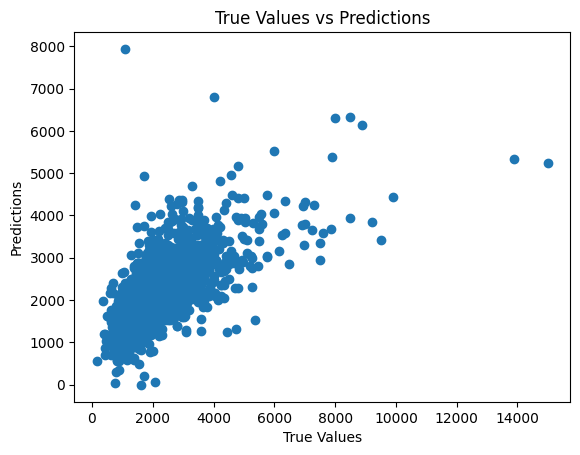

In [21]:
df = pd.read_csv("../preparation/flatfox_no_parking_clean.csv", low_memory=False)


X = df[["object_category","object_type","price_display_type","price_unit","number_of_rooms","floor","is_furnished","is_temporary","is_selling_furniture","zipcode", "city", "latitude","longitude","year_built","year_renovated","moving_date_type","reserved","livingspace"]] 

y = df["price_display"] 


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Initialize the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')



# Plot true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [22]:
location_data = df[['latitude', 'longitude']]

# Define the number of clusters (you can adjust this number)
n_clusters = 1000
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
location_clusters = kmeans.fit_predict(location_data)

# Add the location clusters to the dataframe
df['location_cluster'] = location_clusters

## Random Forest
Removed: City, year_built, object_category, is_selling_furniture

Mean Squared Error: 287297.5544643045
R-squared Score: 0.754623804051344
Error: 536.0014500580241


/home/lukaswipf/zhaw/semester5/DAAI/schweizerland/project/daai-gg-flatfox/.venv/lib64/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


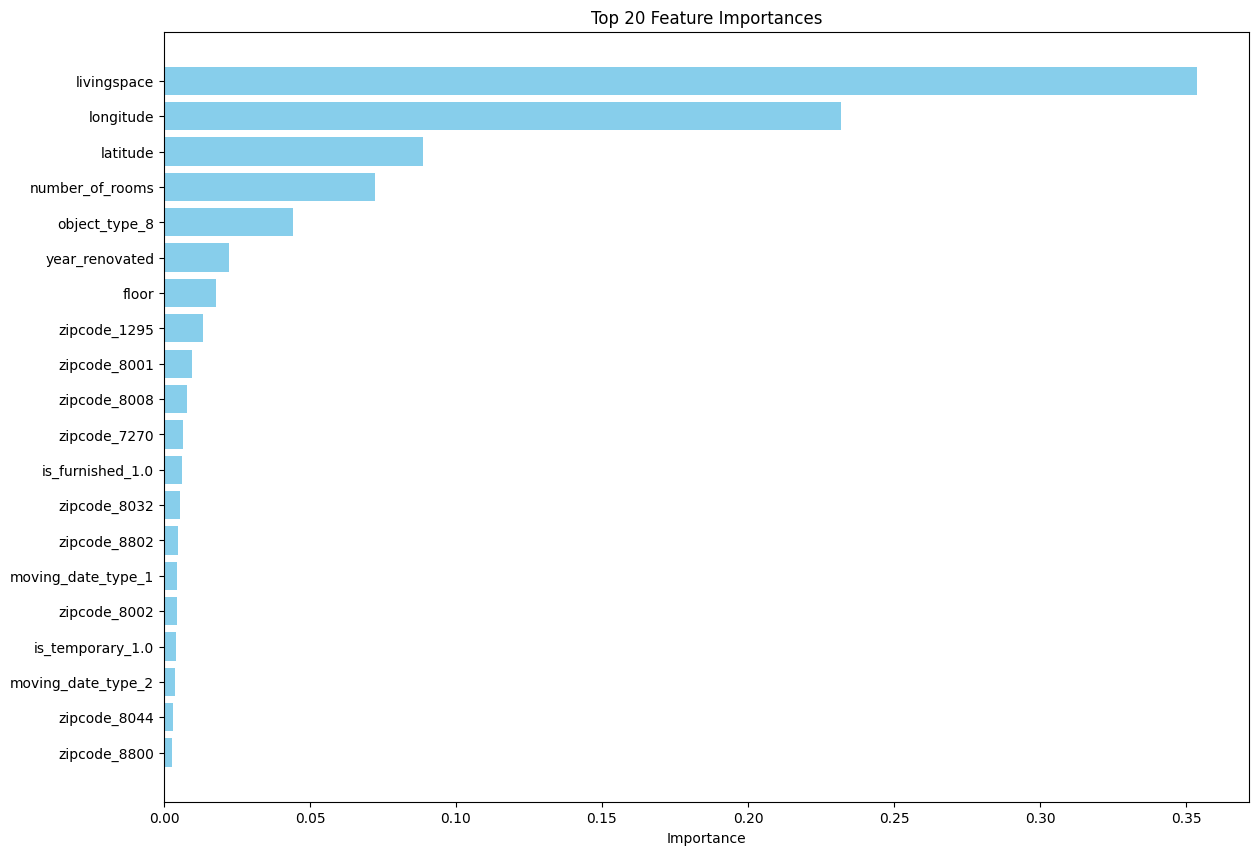

In [23]:
# Suppress specific warning
# Define features and target
X = df[["object_type","price_display_type","price_unit","number_of_rooms","floor","is_furnished","is_temporary","zipcode","latitude","longitude","year_renovated","moving_date_type","reserved","livingspace"]]

y = df["price_display"]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['price_unit', 'number_of_rooms', 'floor', 'latitude', 'longitude', 'year_renovated', 'reserved', 'livingspace']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['object_type', 'price_display_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')


# Extract feature importances
feature_importances = pipeline.named_steps['model'].feature_importances_

# Extract feature names
num_features = preprocessor.transformers_[0][2]
cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['object_type', 'price_display_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary'])
all_features = np.concatenate([num_features, cat_features])

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Limit the number of features shown for better readability (e.g., top 20 features)
top_n = 20
top_features = feature_importance_df.head(top_n)

# Plot the feature importances
plt.figure(figsize=(14, 10))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
plt.show()


Error: 534.7783409292404

## XGBoost
Removed: City, year_built, object_category, is_selling_furniture

(pray to the Omnissiah) this works, 16/9 will provide us assistance

In [27]:
# Suppress specific warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define features and target
X = df[["object_type", "number_of_rooms","floor","is_furnished","is_temporary","zipcode","latitude","longitude","year_renovated","moving_date_type","reserved","livingspace"]]
y = df["price_display"]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['number_of_rooms', 'floor', 'latitude', 'longitude', 'year_renovated', 'reserved', 'livingspace']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['object_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=200, random_state=5))
])
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Mean Squared Error: 292742.5884177498
R-squared Score: 0.7499732885925579
Error: 541.0569179095206


## XGBoost Hyper Parameter Tuning
Removed: City, year_built, object_category, is_selling_furniture


In [29]:
from sklearn.model_selection import GridSearchCV
# Suppress specific warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

# Define features and target
X = df[["object_type","number_of_rooms","floor","is_furnished","is_temporary","zipcode","latitude","longitude","year_renovated","moving_date_type","livingspace"]]
y = df["price_display"]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['number_of_rooms', 'floor', 'latitude', 'longitude', 'year_renovated','livingspace']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['object_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=0))
])

vals = np.linspace(0.01, 0.2, 20)

# Define parameter grid
param_grid = {
    'model__n_estimators': [400],
    'model__max_depth': [7],
    'model__learning_rate': [0.1],
    'model__subsample': [0.7],
    'model__colsample_bytree': [0.8]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=7, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best parameters: {grid_search.best_params_}')

# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

test_flat = {
    "object_category": [0],
    "object_type": [8],
    "price_display": [3100],
    "price_display_type": [1],
    "price_unit": [0],
    "number_of_rooms": [2],
    "floor": [0],
    "is_furnished": [1],
    "is_temporary": [0],
    "is_selling_furniture": [0],
    "zipcode": [8003],
    "city": [1746],
    "latitude": [47.36764161],
    "longitude": [8.521921235],
    "year_built": [39.47986307],
    "year_renovated": [7],
    "moving_date_type": [2],
    "reserved": [0],
    "livingspace": [60]
}

test_pred = best_model.predict(pd.DataFrame(test_flat))
print(test_pred)


/home/lukaswipf/zhaw/semester5/DAAI/schweizerland/project/daai-gg-flatfox/.venv/lib64/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/lukaswipf/zhaw/semester5/DAAI/schweizerland/project/daai-gg-flatfox/.venv/lib64/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/lukaswipf/zhaw/semester5/DAAI/schweizerland/project/daai-gg-flatfox/.venv/lib64/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/lukaswipf/zhaw/semester5/DAAI/schweizerland/project/daai-gg-flatfox/.venv/lib64/python3.12/site-packages/sklearn/pr

Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 400, 'model__subsample': 0.7}
Mean Squared Error: 272353.1652911673
R-squared Score: 0.7673875652080241
Error: 521.874664350711
[3256.5103]


Best parameters:
```javascript
{
    'model__colsample_bytree': 0.8,
    'model__learning_rate': 0.1,
    'model__max_depth': 7,
    'model__n_estimators': 400,
    'model__subsample': 0.7
}
```

Mean Squared Error: 250534.30200750157\
R-squared Score: 0.7860227035490116\
Error: 500.5340168335231


## test

In [30]:
BASE_URL = "https://flatfox.ch"
API_BASE = "api/v1/public-listing"

def predict_price(url):
    if type(url) is str:
        pk = re.search(r"https://flatfox.ch/\w{2,3}/flat/.+/(\d+)/", url).group(1)
    else:
        pk = url
    QUERY = f"pk={pk}" 
    response = requests.get(f"{BASE_URL}/{API_BASE}/?{QUERY}").json()
    response = response["results"][0]
    
    
    if response['price_display'] is None:
        print("Price not available.")
        print(response)
        return
    
    
    df_inner = pd.DataFrame.from_dict([response], orient='columns')
    price = response['price_display']
    print(f"Price:\t\t\t\t{price}")
    pred = best_model.predict(df_inner)[0]
    print(f"Predicted price:\t{pred}")
    print(f"Difference:\t\t\t{abs(price - pred)}")

[flatfox](https://flatfox.ch/en/search/?east=10.220813&north=48.317948&object_category=APARTMENT&offer_type=RENT&ordering=-insertion)

In [31]:
urls = [
    "https://flatfox.ch/en/flat/schutzenmattstrasse-16-4051-basel/1264046/",
    "https://flatfox.ch/en/flat/fluhmattstrasse-56-6004-luzern/1229725/",
    "https://flatfox.ch/en/flat/leimenstrasse-41-4051-basel/1264052/",
    "https://flatfox.ch/en/flat/kesselweg-17-4410-liestal/1228866/",
    "https://flatfox.ch/en/flat/birkenstrasse-6-6003-luzern/1263760/",
    "https://flatfox.ch/en/flat/tuchmacherstrasse-34-8041-zurich/1263838/",
    "https://flatfox.ch/en/flat/gerliswilstrasse-49-6020-emmenbrucke/1264056/",
    "https://flatfox.ch/en/flat/schonauerstrasse-2-9533-dietschwil-sg/1264019/"
]

print("-" * 100)
for url in urls:
    predict_price(url)
    print("-" * 100)

----------------------------------------------------------------------------------------------------
Price:				1750
Predicted price:	1735.288818359375
Difference:			14.711181640625
----------------------------------------------------------------------------------------------------
Price:				850
Predicted price:	1205.073974609375
Difference:			355.073974609375
----------------------------------------------------------------------------------------------------
Price:				2450
Predicted price:	2537.31494140625
Difference:			87.31494140625
----------------------------------------------------------------------------------------------------
Price:				1750
Predicted price:	1852.8665771484375
Difference:			102.8665771484375
----------------------------------------------------------------------------------------------------
Price:				1810
Predicted price:	1927.699951171875
Difference:			117.699951171875
---------------------------------------------------------------------------------------------

In [32]:
url = "https://flatfox.ch/en/flat/oberwaldstr-24-9205-waldkirch/1255471/"

predict_price(url)
predict_price(1255471)

Price:				1735
Predicted price:	1868.3114013671875
Difference:			133.3114013671875
Price:				1735
Predicted price:	1868.3114013671875
Difference:			133.3114013671875
